## Def

In [3]:
import os
import requests
import json
import time
from datetime import datetime

BASE_URL = 'http://localhost:1234'

def read_token(file_path='./token.txt'):
    try:
        with open(file_path, 'r') as file:
            return file.read().strip()
    except IOError as err:
        print(f'Error reading token from file: {err}')
        return None
    

def get_headers(token):
    return {
        'Authorization': f'Bearer {token}',
        'Content-Type': 'application/json'
    }

token = read_token()

def write_token(token):
    if not os.path.exists('token.txt'):
        with open('token.txt', 'w') as f:
            f.write(token)
    else:
        with open('token.txt', 'w') as f:
            f.write(token)
        
def register(user_name, pwd, email):
    try:
        response = requests.post(
            f'{BASE_URL}/users/register',
            json={
                'user_name': user_name,
                'pwd': pwd,
                'email': email,
            }
        )
        response.raise_for_status()
        token = response.json().get('token', '')
        if token:
            write_token(token)
    except requests.exceptions.RequestException as err:
        print(f'Registration error: {err}')

def login(user_name, pwd):
    try:
        response = requests.post(
            f'{BASE_URL}/users/login',
            json={
                'user_name': user_name,
                'pwd': pwd,
            }
        )
        response.raise_for_status()
        token = response.json().get('token', '')
        if token:
            write_token(token)
    except requests.exceptions.RequestException as err:
        print(f'Login error: {err}')
            
def get_momentum():
    try:
        response = requests.get(f'{BASE_URL}/marketindex/momentum', headers=get_headers(token))
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as err:
        print(f'Error fetching momentum: {err}')
        return None

def record_my_transactions(transactions):
    try:
        for stock_id, transaction_type, quantity, price in transactions:
            data = {
                'stock_id': stock_id,
                'transaction_type': transaction_type,
                'quantity': quantity,
                'price': price,
                'transaction_date': datetime.now().strftime('%Y-%m-%d')
            }
            response = requests.post(f'{BASE_URL}/transactions', headers=get_headers(token), json=data)
            if response.status_code in range(200, 300):
                print(f'Successfully inserted: {data}')
            else:
                print(f'Failed to insert: {data}, Status code: {response.status_code}, Response: {response.text}')
            time.sleep(2)
    except requests.exceptions.RequestException as err:
        print(f'Error recording transactions: {err}')

def get_my_portfolio():
    try:
        response = requests.get(f'{BASE_URL}/portfolio', headers=get_headers(token))
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as err:
        print(f'Error fetching portfolio: {err}')
        return None

def get_technews_by_keyword(keyword):
    try:
        response = requests.get(f"{BASE_URL}/technews/search?keyword={keyword}", headers=get_headers(token))
        response.raise_for_status()
        data = response.json()
        return data[::-1]  # 反转列表
    except requests.exceptions.RequestException as err:
        print(f'Error fetching technews: {err}')
        return None
    
def getAllTechnews (page, size):
    if not isinstance(page, int) or not isinstance(size, int) or page <= 0 or size <= 0:
        print('Valid page & size required')
        return []

    params = f"page={page}&size={size}"
    try:
        response = requests.get(f"{BASE_URL}/technews?{params}", headers=get_headers(token))
        response.raise_for_status()
        data = response.json()
        return data[::-1]  # 反转列表
    except requests.exceptions.RequestException as err:
        print(f'Error fetching technews: {err}')
        return None
    
def create_one_company_news (params):
	try:
		response = requests.post(f"{BASE_URL}/company-news", headers=get_headers(token), json=params)
		response.raise_for_status()
		return response.json()
	except requests.exceptions.RequestException as err:
		print(f'Error post company_news: {err}')
		return None
    
def get_all_company_news (page, size):
	if not isinstance(page, int) or not isinstance(page, int) or page <= 0 or size <=0:
		print('Valid page & size required')
		return []

	params = f"page={page}&size={size}"
	try:
		response = requests.get(f"{BASE_URL}/company-news?{params}", headers=get_headers(token))
		response.raise_for_status()
		return response.json()
	except requests.exceptions.RequestException as err:
		print(f'Error fetching technews: {err}')
		return None

### 登入

In [2]:
login(user_name='lewis7063', pwd='a123456+')

#### 註冊

In [ ]:
register(user_name='lewis7063', pwd='a123456+', email='lewis.lee@gmail.com')

### 取得動能指標

In [4]:
my_data = get_momentum()
print(my_data)

[{'createdAt': '2024-03-27 04', 'volume': 1.38}, {'createdAt': '2024-03-27 06', 'volume': 1.39}, {'createdAt': '2024-03-27 07', 'volume': 1.25}, {'createdAt': '2024-03-27 08', 'volume': 1.22}, {'createdAt': '2024-03-27 09', 'volume': 1.32}, {'createdAt': '2024-03-28 02', 'volume': 1.1}, {'createdAt': '2024-03-28 03', 'volume': 1.13}, {'createdAt': '2024-03-28 04', 'volume': 1.24}, {'createdAt': '2024-03-28 06', 'volume': 1.35}, {'createdAt': '2024-03-28 08', 'volume': 1.43}, {'createdAt': '2024-03-28 09', 'volume': 1.42}, {'createdAt': '2024-03-29 02', 'volume': 1.45}, {'createdAt': '2024-03-29 03', 'volume': 1.4}, {'createdAt': '2024-03-29 04', 'volume': 1.37}, {'createdAt': '2024-03-29 06', 'volume': 1.4}, {'createdAt': '2024-03-29 07', 'volume': 1.24}, {'createdAt': '2024-03-29 08', 'volume': 1.29}, {'createdAt': '2024-03-29 09', 'volume': 1.22}, {'createdAt': '2024-03-29 10', 'volume': 1.29}, {'createdAt': '2024-04-01 02', 'volume': 1.51}, {'createdAt': '2024-04-01 03', 'volume': 1

#### 畫出動能

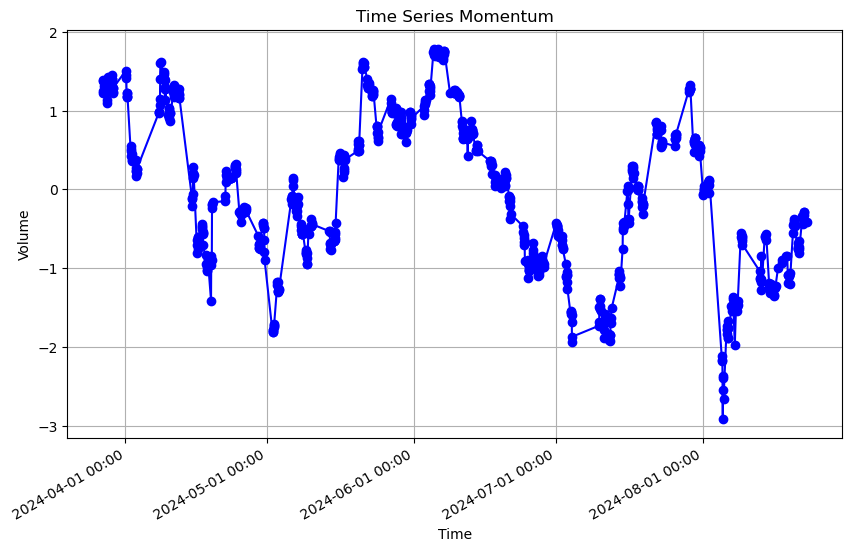

In [5]:

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter

# 将数据转换为 DataFrame
df = pd.DataFrame(my_data)

# 将 'createdAt' 列转换为日期时间对象
df['createdAt'] = pd.to_datetime(df['createdAt'])

# 绘制时间序列数据
plt.figure(figsize=(10, 6))
plt.plot(df['createdAt'], df['volume'], marker='o', linestyle='-', color='b')

# 格式化 x 轴的时间显示
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))

# 设置标题和标签
plt.title('Time Series Momentum')
plt.xlabel('Time')
plt.ylabel('Volume')

# 显示网格
plt.grid(True)

# 自动调整 x 轴日期标签显示
plt.gcf().autofmt_xdate()

# 显示图形
plt.show()

### 記錄交易

In [6]:
transactions = [
	('GOOG', 'buy', 1, 167.72),
]

In [7]:
record_my_transactions(transactions)

Successfully inserted: {'stock_id': 'GOOG', 'transaction_type': 'buy', 'quantity': 1, 'price': 167.72, 'transaction_date': '2024-08-23'}


### MY Portfolio

In [8]:
my_portfolio = get_my_portfolio()
for item in my_portfolio:
	quantity = item.get('quantity', '?')
	average_price = item.get('average_price', '?')
	stock_id = item.get('stock_id', '?')
	print(stock_id + ' ' + str(quantity) + ' * ' + str(average_price) + '\n')

META 0 * 471.51

SNPS 7 * 536.70

PANW 12 * 275.15

GOOG 27 * 152.30

DDOG 29 * 122.24

AMD 65 * 152.04

AVGO 2 * 288.40

NVDA 59 * 108.01

TSLA 24 * 188.81

MU 42 * 127.49

PLTR 37 * 17.18

MRVL 62 * 60.62

LRCX 1 * 869.51

MSFT 2 * 414.78

ON 25 * 75.16

CRWD 10 * 261.48

SOXX 3 * 218.61



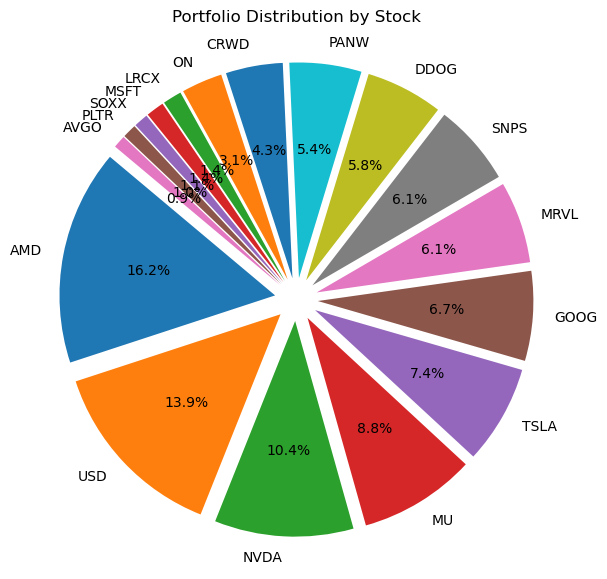

In [9]:
import matplotlib.pyplot as plt

# 计算每个 stock_id 的总价值
portfolio_values = {}
for item in my_portfolio:
    stock_id = item['stock_id']
    quantity = item['quantity']
    average_price = float(item['average_price'])  # 转换为浮点数
    total_value = quantity * average_price
    if stock_id in portfolio_values:
        portfolio_values[stock_id] += total_value
    else:
        portfolio_values[stock_id] = total_value

# 计算投资组合中剩余的 USD 价值
portfolio_values['USD'] = 3365 + 5146.64

portfolio_values = {k: v for k, v in portfolio_values.items() if v > 0}

sorted_portfolio_values = dict(sorted(portfolio_values.items(), key=lambda item: item[1], reverse=True))

# 准备数据绘制饼图
labels = sorted_portfolio_values.keys()
sizes = sorted_portfolio_values.values()
colors = plt.get_cmap('tab10').colors  # 使用预设的颜色映射
explode = [0.1] * len(labels)  # 使每个切片稍微突出

# 绘制饼图
plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Portfolio Distribution by Stock')
plt.show()

### 測試搜新聞

In [10]:
keyword = 'amd'

news = get_technews_by_keyword(keyword)

for item in news:
	title = item.get('title', 'No Title')
	time = item.get('release_time', 'No Time')
	web_url = item.get('web_url', '')
	print(title + ' ' + time + '\n')
	print(web_url + '\n')

英特爾處理器狀況不斷，AMD 韓國 DIY 市場超車 2024-08-22 12:00

https://technews.tw/2024/08/22/amd-has-overtaken-dominance-in-south-koreas-diy-market/

英特爾處理器狀況不斷，AMD 已在韓國 DIY 市場超車主導地位 2024-08-22 12:00

https://technews.tw/2024/08/22/amd-has-overtaken-dominance-in-south-koreas-diy-market/

【美股新聞】AMD 併購 ZT 卻決定賣出製造部門，有望追上輝達？ 2024 年 8 月 20 日

https://magnifier.cmoney.tw/%e8%b6%85%e5%be%ae%e4%bd%b5%e8%b3%bc-zt/

經濟部證實，AMD 研發據點選定台南與高雄 2024-08-21 17:40

https://technews.tw/2024/08/21/amd-rd-base-taiwan/

AMD 擬售 ZT Systems 製造業務，大摩看有利三台廠 2024-08-20 17:55

https://technews.tw/2024/08/20/morgan-stanley-see-amd-buy-zt-systems/

AMD 擬售 ZT Systems 製造業務，大摩看有利 3 台廠 2024-08-20 17:55

https://technews.tw/2024/08/20/morgan-stanley-see-amd-buy-zt-systems/

AMD 大手筆收購 ZT Systems，金額超過 2024 年 AI 晶片營收 2024-08-20 10:10

https://finance.technews.tw/2024/08/20/amd-makes-big-acquisition-of-zt-systems/

為何以超過 2024 年全年 AI 晶片營收，AMD 大手筆收購 ZT Systems 2024-08-20 10:10

https://technews.tw/2024/08/20/amd-makes-big-acquisition-of-zt-system

In [ ]:
all_news = getAllTechnews(page=1, size=500)
for item in all_news:
	title = item.get('title', 'No Title')
	time = item.get('release_time', 'No Time')
	web_url = item.get('web_url', '')
	print(title + ' ' + time + '\n')
	print(web_url + '\n')

#### 搜索Company news

In [11]:
all_news = get_all_company_news(page=1, size=200)

for item in all_news:
	title = item.get('title', 'No Title')
	time = item.get('release_time', 'No Time')
	web_url = item.get('web_url', '')
	print(title + ' ' + time + '\n')
	print(web_url + '\n')

S&P 500's top 5 stocks in June (Nvidia isn't one of them!) 2024-08-21T11:58:00.000Z

https://finance.yahoo.com/m/8ad0a35b-9e19-3291-bd43-eaeab0ee9abb/s%26p-500%27s-top-5-stocks-in.html

20 Most Technologically Advanced Cities in the US 2024-08-20T16:00:00.000Z

https://www.insidermonkey.com/blog/20-most-technologically-advanced-cities-in-the-us-1318631/

Decoding Adobe Inc (ADBE): A Strategic SWOT Insight 2024-08-20T17:01:00.000Z

https://finance.yahoo.com/news/decoding-adobe-inc-adbe-strategic-050116869.html

Here's how to pick the best stocks for the second half of the year 2024-08-20T18:52:00.000Z

https://finance.yahoo.com/news/heres-pick-best-stocks-second-065219723.html

Why Did Analysts Give Adobe, Inc. (ADBE) a Moderate Buy Rating? 2024-08-20T16:00:00.000Z

https://www.insidermonkey.com/blog/why-did-analysts-give-adobe-inc-adbe-a-moderate-buy-rating-1319412/

3 Social Media Stocks That Could Make Your Grandchildren Rich 2024-08-20T16:00:00.000Z

https://investorplace.com/2024/0

#### 讀取Html 轉成json資料

In [4]:
symbol = 'MU'

In [5]:
from bs4 import BeautifulSoup
from datetime import datetime, timezone

with open('index.html', 'r', encoding='utf-8') as file:
	html_content = file.read()

soup = BeautifulSoup(html_content, 'html.parser')

news = []

for row in soup.find_all('tr', class_='cursor-pointer has-label'):
	time_cell = row.find('td', align='right')
	time_text = time_cell.get_text(strip=True).replace('Today', '')

	if 'Today' in time_text:
		time_text = time_text.replace('Today', '')
		now = datetime.now(timezone.utc)
		date_str = now.date().isoformat()
	else:
		now = datetime.now(timezone.utc)
		date_str = now.date().isoformat()

	try:
		time_obj = datetime.strptime(time_text, '%I:%M%p')
		time_24hr = time_obj.strftime('%H:%M:%S')
	except ValueError:
		# 如果时间格式无法解析，使用默认时间
		time_24hr = '00:00:00'
		
	# 创建 MySQL 支持的时间字符串
	release_time = f"{date_str} {time_24hr}"

	link = row.find('a', class_='tab-link-news')
	title = link.get_text(strip=True)
	web_url = link['href']

	publisher = row.find('span').get_text(strip=True).strip('()')

	news_item = {
        "title": title,
        "symbol": symbol,
        "release_time": release_time,
        "publisher": publisher,
        "web_url": web_url
    }

	news.append(news_item)

print(json.dumps(news, indent=4))


[
    {
        "title": "Buy This Semiconductor Stock Amid Unprecedented AI Memory Cycle, Analyst Says",
        "symbol": "MU",
        "release_time": "2024-08-23 00:00:00",
        "publisher": "Barrons.com",
        "web_url": "https://finance.yahoo.com/m/3ac05a66-f99e-38e9-aadb-b05b15c4c3ae/buy-this-semiconductor-stock.html"
    },
    {
        "title": "Prediction: These 2 Growth Stocks Could Start Soaring After Nvidia's Quarterly Earnings on Aug. 28",
        "symbol": "MU",
        "release_time": "2024-08-23 04:15:00",
        "publisher": "Motley Fool",
        "web_url": "https://finance.yahoo.com/m/0a617701-1a41-399d-aa5c-445c0dd225be/prediction%3A-these-2-growth.html"
    },
    {
        "title": "Nvidia Eyes Return to Record as AI Spending Bonanza Continues",
        "symbol": "MU",
        "release_time": "2024-08-23 00:00:00",
        "publisher": "Bloomberg",
        "web_url": "https://finance.yahoo.com/news/nvidia-eyes-return-record-ai-112116061.html"
    },
    {

#### 多筆寫入至資料庫 Company_news

In [ ]:
url = BASE_URL + '/company-news/bulk'

response = requests.post(url, headers=headers, json=news)

print(f"Status Code: {response.status_code}")
print("Response Text:", response.text)

try:
    response_data = response.json()
    print(json.dumps(response_data, indent=2))
except ValueError as e:
    # 捕获并打印异常详细信息
    print(f"Failed to parse JSON: {e}")
    print("Response Text:", response.text)

#### 單筆寫入

In [6]:
from time import sleep

for item in news:
	res = create_one_company_news(item)
	print(res)
	sleep(1)

{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
{'message': 'Company news created successfully.'}
Error post company_news: 500 Server Error: Interna

#### 取得statement

In [ ]:
symbo = 'nvda'

In [ ]:
req_url = f"{BASE_URL}/statements/{symbo}"

response = requests.get(req_url, headers=headers)

if response.status_code == 200:
    data = response.json()
    data.reverse()
    print(data)
    for item in data:
        pef = item.get('PE_Forward', 'No PE_Forward')
        symbo = item.get('symbo', 'No symbo')
        time = item.get('createdAt', 'No Time')
        print(symbo + ' === Forward PE : ' + pef + '   ' +  time + '\n')
else:
    print('Request failed with status code:', response.status_code)